In [331]:
import glob

import torch
import numpy as np
from scipy.io import loadmat, savemat
from scipy.signal import resample

from scipy.io import savemat, loadmat
from scipy.signal import resample
from scipy.interpolate import interp1d


from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *
from motormetrics.ee import get_ramp_from_sim_reference

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [332]:
def smooth(x,window_len,window):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [333]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

model_spd_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd_n.eval()
model_trq_n.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [334]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

In [399]:
data1 = loadmat('../../../datasets/Data_27012021_noisy/benchmark/real7.mat')
data2 = loadmat('../../../datasets/Data_27012021_noisy/real_noimpulse/torque_step_0-100_50Hz_closed_loop_mod.mat')

In [336]:
data1 = loadmat('../../../datasets/Data_27012021_noisy/benchmark/real7.mat')
data2 = loadmat('../../../datasets/Data_27012021_noisy/real_noimpulse/torque_step_0-100_50Hz_closed_loop_mod.mat')


st = 0
et = -1

x_id = np.stack([data2['noisy_current_d'][0] / 30]) 
x_iq = np.stack([data2['noisy_current_q'][0] / 30])
x_ud = np.stack([data2['noisy_voltage_d'][0] / 300]) 
x_uq = np.stack([data2['noisy_voltage_q'][0] / 300])

x_d = np.stack([[x_id[0], x_iq[0], x_ud[0], x_uq[0]]])


inp_id = torch.tensor([x_id[:, st:et]]).cuda().float()
out_id = model_id(inp_id)
out_id_da = out_id.data.cpu().numpy()[0]
out_id_wt = wt(data2['noisy_current_d'][0], 0.17)
out_id_ekf = ekf(data2['noisy_current_d'][0], 0.17)
out_id_tv = tv(data2['noisy_current_d'][0], 0.17)

inp_iq = torch.tensor([x_iq[:, st:et]]).cuda().float()
out_iq = model_iq(inp_iq)
out_iq_da = out_iq.data.cpu().numpy()[0]
out_iq_wt = wt(data2['noisy_current_q'][0], 0.29)
out_iq_ekf = ekf(data2['noisy_current_q'][0], 0.29)
out_iq_tv = tv(data2['noisy_current_q'][0], 0.29)

inp_ud = torch.tensor([x_ud[:, st:et]]).cuda().float()
out_ud = model_ud(inp_ud)
out_ud_da = out_ud.data.cpu().numpy()[0]
out_ud_wt = wt(data2['noisy_voltage_d'][0], 1.85)
out_ud_ekf = ekf(data2['noisy_voltage_d'][0], 1.85)
out_ud_tv = tv(data2['noisy_voltage_d'][0], 1.85)

inp_uq = torch.tensor([x_uq[:, st:et]]).cuda().float()
out_uq = model_uq(inp_uq)
out_uq_da = out_uq.data.cpu().numpy()[0]
out_uq_wt = wt(data2['noisy_voltage_q'][0], 1.78)
out_uq_ekf = ekf(data2['noisy_voltage_q'][0], 1.78)
out_uq_tv = tv(data2['noisy_voltage_q'][0], 1.78)

inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                       out_iq_da[0], 
                                       out_ud_da[0], 
                                       out_uq_da[0]]])).cuda()
inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                       out_iq_wt / 30, 
                                       out_ud_wt / 300, 
                                       out_uq_wt / 300]])).cuda().float()
inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                       out_iq_ekf / 30, 
                                       out_ud_ekf / 300, 
                                       out_uq_ekf / 300]])).cuda().float()
inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                       out_iq_tv / 30, 
                                       out_ud_tv / 300, 
                                       out_uq_tv / 300]])).cuda().float()
inps_d = torch.from_numpy(x_d).cuda().float()

out_spd_da = model_spd(inps_da)
out_spd_da = out_spd_da.data.cpu().numpy()[0]
out_spd_wt = model_spd(inps_wt)
out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
out_spd_ekf = model_spd(inps_ekf)
out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
out_spd_tv = model_spd(inps_tv)
out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
out_spd_d = model_spd_n(inps_d)
out_spd_d = out_spd_d.data.cpu().numpy()[0]

out_trq_da = model_trq(inps_da)
out_trq_da = out_trq_da.data.cpu().numpy()[0]
out_trq_wt = model_trq(inps_wt)
out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
out_trq_ekf = model_trq(inps_ekf)
out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
out_trq_tv = model_trq(inps_tv)
out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
out_trq_d = model_trq(inps_d)
out_trq_d = out_trq_d.data.cpu().numpy()[0]

In [337]:
alpha = 0.1
speed_pred_d = out_spd_d[0] * 80
speed_pred_d = alpha * speed_pred_d + (1 - alpha) * data2['speed'][0]

torque_pred_d = out_trq_d[0] * 120
torque_pred_d = alpha * torque_pred_d + (1 - alpha) * data2['torque'][0]

alpha = 0.009
speed_pred_md = np.copy(data2['speed'][0])
speed_pred_md[:-1] = out_spd_da[0] * 80
speed_pred_md = alpha * speed_pred_md + (1 - alpha) * data2['speed'][0]

torque_pred_md = np.copy(data2['torque'][0])
torque_pred_md[:-1] = out_trq_da[0] * 120
torque_pred_md = alpha * torque_pred_md + (1 - alpha) * data2['torque'][0]


alpha = 0.09
speed_pred_da = np.copy(data2['speed'][0])
speed_pred_da[:-1] = out_spd_da[0] * 80
speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data2['speed'][0]

torque_pred_da = np.copy(data2['torque'][0])
torque_pred_da[:-1] = out_trq_da[0] * 120
torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data2['torque'][0]

alpha = 0.14
speed_pred_wt = out_spd_wt[0] * 80
speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data2['speed'][0]

torque_pred_wt = out_trq_wt[0] * 120
torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data2['torque'][0]

alpha = 0.15
speed_pred_ekf = out_spd_ekf[0] * 80
speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data2['speed'][0]

torque_pred_ekf = out_trq_ekf[0] * 120
torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data2['torque'][0]

alpha = 0.1
speed_pred_tv = out_spd_tv[0] * 80
speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data2['speed'][0]

torque_pred_tv = out_trq_tv[0] * 120
torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data2['torque'][0]

-1499 -1499


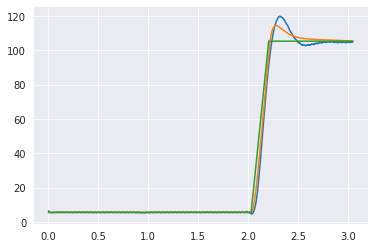

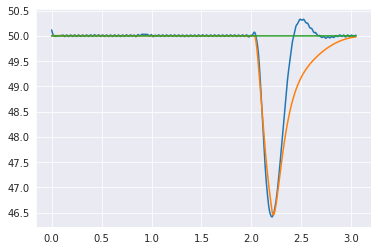

102.75


In [400]:
st2 = int(0)
et2 = int(3 // 0.002)

st1 = int(102.752 // 0.002) 
et1 = int(105.750 // 0.002) 

print (st2-et2, st1-et1)

plt.plot(data2['time'][0, st2:et2], data2['torque'][0, st2:et2])
plt.plot(data2['time'][0, st2:et2], data1['torque'][0, st1:et1])
plt.plot(data2['time'][0, st2:et2], data1['reference_torque_interp'][0, st1:et1])
plt.show()

plt.plot(data2['time'][0, st2:et2], data2['speed'][0, st2:et2])
plt.plot(data2['time'][0, st2:et2], data1['speed'][0, st1:et1])
plt.plot(data2['time'][0, st2:et2], data1['reference_speed_interp'][0, st1:et1])
plt.show()

print (data1['time'][0, int(102.752 // 0.002)])

In [401]:
st2 = int(0)
et2 = int(3 // 0.002)

st1 = int(102.752 // 0.002) 
et1 = int(105.750 // 0.002) 

data1n = {}
for k in data1.keys():
    if '__' not in k:
        data1n[k] = data1[k][:, st1:et1]

data1n['time'] -= 102.752
data1n['reference_speed'] = [data1['reference_speed'][0][2:]]
data1n['reference_torque'] = [data1['reference_torque'][0][2:]]
data1n['speed_time'] = np.asarray([[ 102.752, 104.724, 104.904, 105.750-0.004]]) - 102.752
data1n['torque_time'] = np.asarray([[ 102.752, 104.724, 104.904, 105.750-0.004]]) - 102.752
print (data1n['speed_time'])
# print ('--------- Real Sim-----------')
# compute_ee(data1n, data1n['speed'][0], data1n['torque'][0])

print ('--------- Real Motor-----------')
compute_ee(data1n, data2['speed'][0][st2-0:et2-0], data2['torque'][0][st2-0:et2-0])

print ('--------- Case D ----------')
compute_ee(data1n, speed_pred_d[st2-0:et2-0], torque_pred_d[st2-0:et2-0])
compute_ml(data1n, speed_pred_d[st2-0:et2-0], torque_pred_d[st2-0:et2-0])

# print ('--------- EKF ----------')
# compute_ee(data1n, speed_pred_ekf[st1-0:et1-0], torque_pred_ekf[st1-0:et1-0])

# print ('--------- WT ----------')
# compute_ee(data1n, speed_pred_wt[st1-0:et1-0], torque_pred_wt[st1-0:et1-0])

# print ('--------- TV -----------')
# compute_ee(data1n, speed_pred_tv[st1-0:et1-0], torque_pred_tv[st1-0:et1-0])

# print ('--------- DA ----------')
# compute_ee(data1n, speed_pred_da[st1-0:et1-0], torque_pred_da[st1-0:et1-0])

print ('--------- MD ----------')
compute_ee(data1n, speed_pred_md[st2-0:et2-0], torque_pred_md[st2-0:et2-0])
compute_ml(data1n, speed_pred_md[st2-0:et2-0], torque_pred_md[st2-0:et2-0])

[[0.    1.972 2.152 2.994]]
--------- Real Motor-----------
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'max_trq_accs': [], 'max_trq_acc_times': []}
{'perc2_times': [0.038], 'perc95_times': [0.406], 'following_errs': [22.9541], 'following_times': [2.064], 'overshoot_errs': [14.561], 'overshoot_times': [2.26], 'ramp_start_times': [1.9720000000000084], 'sse_errs': [0.5264], 'sse_times': [2.894], 'speed_drops': [3.5841], 'speed_drops_times': [2.152]}
--------- Case D ----------
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'max_trq_accs': [], 'max_trq_acc_times': []}
{'perc2_times': [0.038], 'perc95_times': [0.418], 'following_errs': [22.3593], 'following_times': [2.064], 'overshoot_errs': [15.6793], 'overshoo

In [413]:
st2 = int(1 // 0.002)
et2 = int(3 // 0.002)

st1 = int(103.750 // 0.002)
et1 = int(105.750 // 0.002) 



sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_current_d'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['current_d'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], out_id_tv[st2:et2][::3], 'b', label="MD", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_id.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_current_q'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['current_q'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], out_iq_tv[st2:et2][::3], 'b', label="MD", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_q$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_iq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_voltage_d'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['voltage_d'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], (0.5 * out_ud_da[0][st2:et2] * 300 + 0.5 * out_ud_tv[st2:et2])[::3], 'b', label="MD", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_d$ (V)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
# plt.show()
plt.savefig('real2_ud.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_voltage_q'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
# plt.plot(data1['time'][0, st1:et1], data1['voltage_q'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], (0.5 * out_uq_da[0][st2:et2] * 300 + 0.5 * out_uq_tv[st2:et2])[::3], 'b', label="MD", alpha=0.3)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_q$ (V)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_uq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data1['reference_speed_interp'][0, st1:et1][::3], 'k', label="Reference", alpha=1)
# plt.plot(data1['time'][0, st1:et1], data1['speed'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_speed'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
plt.plot(data2['time'][0, st2:et2][::3], data2['speed'][0, st2:et2][::3], 'k--', label="Non-Noisy\n(Reconstructed)", alpha=0.5)
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], (0.2 * speed_pred_d[st2:et2] + 0.8 * data2['noisy_speed'][0, st2:et2])[::3], 'r', label="DiagBiRNN Case D", alpha=0.3)
plt.plot(data2['time'][0, st2:et2][::3], speed_pred_md[st2:et2][::3], 'b', label="MD-DiagBiRNN", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_spd.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data2['time'][0, st2:et2][::3], data1['reference_torque_interp'][0, st1:et1][::3], 'k', label="Reference", alpha=1)
# plt.plot(data1['time'][0, st1:et1], data1['torque'][0, st1:et1], 'k', label="Sim Real")
plt.plot(data2['time'][0, st2:et2][::3], data2['noisy_torque'][0, st2:et2][::3], 'g', label="Noisy\n(Measured)", alpha=0.3)
plt.plot(data2['time'][0, st2:et2][::3], data2['torque'][0, st2:et2][::3], 'k--', label="Non-Noisy\n(Reconstructed)", alpha=0.5)
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], (0.2 * torque_pred_d[st2:et2] + 0.8 * data2['noisy_torque'][0, st2:et2])[::3], 'r', label="DiagBiRNN Case D", alpha=0.3)
plt.plot(data2['time'][0, st2:et2][::3], torque_pred_md[st2:et2][::3], 'b', label="MD-DiagBiRNN", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_trq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
# plt.plot(data['time'][0, st:et], data['speed'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], speed_pred_d[st2:et2][::3] - data2['speed'][0, st2:et2][::3], 'r', label="DiagBiRNN Case D", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], speed_pred_md[st2:et2][::3] - data2['speed'][0, st2:et2][::3], 'b', label="MD-DiagBiRNN", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'Error $\omega_r$ (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_spd_err.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
# plt.plot(data['time'][0, st:et], data['reference_torque_interp'][0, st:et], 'g', label="Ref", alpha=0.3)
# plt.plot(data['time'][0, st:et], data['torque'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], torque_pred_d[st2:et2][::3] - data2['torque'][0, st2:et2][::3], 'r', label="DiagBiRNN Case D", alpha=0.5)
plt.plot(data2['time'][0, st2:et2][::3], torque_pred_md[st2:et2][::3] - data2['torque'][0, st2:et2][::3], 'b', label="MD-DiagBiRNN", alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'Error $\tau_{em}$ (%Nom)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('real2_trq_err.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

# st1 = int(152 / 0.004)
# et1 = int(155 / 0.004)

# sns.set_style("darkgrid")
# plt.plot(data1['time'][0, st1:et1], data1['reference_torque_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# # plt.plot(data1['time'][0, st1:et1], data1['torque'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data2['time'][0, st1-0:et1-0], data2['noisy_torque'][0, st1-0:et1-0], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data2['time'][0, st1-0:et1-0], data2['torque'][0, st1-0:et1-0], 'g--', label="Motor Real")
# # plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# # plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
# plt.plot(data2['time'][0, st1-0:et1-0], torque_pred_d[st1-0:et1-0], 'y', label="DiagBiRNN Case D", alpha=1)
# plt.plot(data2['time'][0, st1-0:et1-0], torque_pred_md[st1-0:et1-0], 'r', label="MD + DiagBiRNN", alpha=1)

# plt.legend(fontsize=12)
# plt.xlabel('Time (s)', fontsize=20)
# plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.plot()
# # plt.show()
# plt.savefig('real2_trq1.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
# plt.close()


# st1 = int(159  / 0.004)
# et1 = int(162  / 0.004)

# sns.set_style("darkgrid")
# plt.plot(data1['time'][0, st1:et1], data1['reference_torque_interp'][0, st1:et1], 'k--', label="Ref", alpha=0.3)
# # plt.plot(data1['time'][0, st1:et1], data1['torque'][0, st1:et1], 'k', label="Sim Real")
# plt.plot(data2['time'][0, st1-0:et1-0], data2['noisy_torque'][0, st1-0:et1-0], 'g', label="Motor Noisy", alpha=0.3)
# plt.plot(data2['time'][0, st1-0:et1-0], data2['torque'][0, st1-0:et1-0], 'g--', label="Motor Real")
# # plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# # plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
# plt.plot(data2['time'][0, st1-0:et1-0], torque_pred_d[st1-0:et1-0], 'y', label="DiagBiRNN Case D", alpha=1)
# plt.plot(data2['time'][0, st1-0:et1-0], torque_pred_md[st1-0:et1-0], 'r', label="MD + DiagBiRNN", alpha=1)

# plt.legend(fontsize=12)
# plt.xlabel('Time (s)', fontsize=20)
# plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.plot()
# # plt.show()
# plt.savefig('real2_trq2.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
# plt.close()

In [406]:
st1 = int(0//0.002)
et1 = int(3//0.002)

# data1n['time'] = data2['time'][0][st1-0:et1-0]

data1n['current_d_MD'] = out_id_tv[st1:et1]
data1n['current_q_MD'] = out_iq_tv[st1:et1]
data1n['voltage_d_MD'] = (0.5 * out_ud_da[0][st1:et1] * 300 + 0.5 * out_ud_tv[st1:et1])
data1n['voltage_q_MD'] = (0.5 * out_uq_da[0][st1:et1] * 300 + 0.5 * out_uq_tv[st1:et1])

data1n['current_d_Motor'] = data2['noisy_current_d'][0][st1-0:et1-0]
data1n['current_q_Motor'] = data2['noisy_current_q'][0][st1-0:et1-0]
data1n['voltage_d_Motor'] = data2['noisy_voltage_d'][0][st1-0:et1-0]
data1n['voltage_q_Motor'] = data2['noisy_voltage_q'][0][st1-0:et1-0]

data1n['speed_Motor'] = data2['noisy_speed'][0][st1-0:et1-0]
data1n['torque_Motor'] = data2['noisy_torque'][0][st1-0:et1-0]

data1n['speed_Real'] = data2['speed'][0][st1-0:et1-0]
data1n['torque_Real'] = data2['torque'][0][st1-0:et1-0]

data1n['speed_CASE_D'] = (0.2 * speed_pred_d[st1:et1] + 0.8 * data2['noisy_speed'][0, st1:et1])
data1n['torque_CASE_D'] = (0.2 * torque_pred_d[st1:et1] + 0.8 * data2['noisy_torque'][0, st1:et1])

w = 51
w_t = "hamming"
data1n['speed_CASE_D_Recon'] = smooth(data1n['speed_CASE_D'], window_len=w, window=w_t)[w//2:-1*w//2+1]
data1n['torque_CASE_D_Recon'] = smooth(data1n['torque_CASE_D'], window_len=w, window=w_t)[w//2:-1*w//2+1]

data1n['speed_EKF'] = speed_pred_ekf[st1-0:et1-0]
data1n['torque_EKF'] = torque_pred_ekf[st1-0:et1-0]

data1n['speed_WT'] = speed_pred_wt[st1-0:et1-0]
data1n['torque_WT'] = torque_pred_wt[st1-0:et1-0]

data1n['speed_MCTV'] = speed_pred_tv[st1-0:et1-0]
data1n['torque_MCTV'] = torque_pred_tv[st1-0:et1-0]

data1n['speed_DAE'] = speed_pred_da[st1-0:et1-0]
data1n['torque_DAE'] = torque_pred_da[st1-0:et1-0]

data1n['speed_MD'] = speed_pred_md[st1-0:et1-0]
data1n['torque_MD'] = torque_pred_md[st1-0:et1-0]

savemat('rdynamic_torque2.mat', data1n)